In [106]:
import re
import random
import pandas as pd
import hashlib

In [107]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.75) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [108]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Logging in Python,329.954178,13.198167,25
SharePoint,770.098503,45.299912,17
Azure Functions,791.009592,49.438099,16
Azure AI Search,878.667311,62.761951,14
Diffusers Library,937.207408,117.150926,8
Home Network Project,1176.257465,61.908288,19
PP365,1257.305187,125.730519,10
Lost in a Good Book,1264.148245,63.207412,20
Taxes,1297.760903,129.776090,10
Azure Functions + PP365,1511.362487,32.156649,47


# Histogram

49709.57


<Axes: >

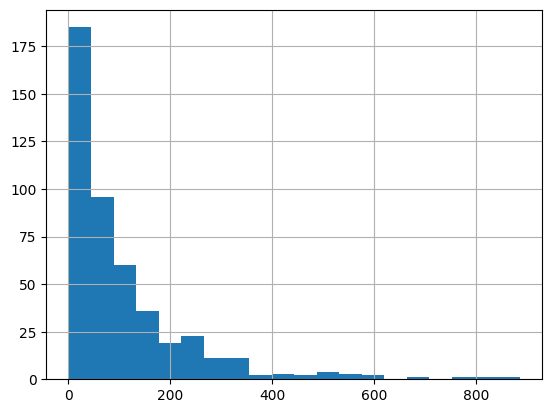

In [109]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [110]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [111]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 461


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
0,Open Source/GitHub,Semantic Versioning\n\nA versioning scheme tha...,9aef26d41b1623fdd93eaeef436024ea,884.702031,113.613411,884.702031,2613.108442,0.732811
1,Email Auth and Security,DKIM (DomainKeys Identified Mail)\n\nAn email ...,991e90ea49a5db4146ebabcbdc7fe747,812.115958,208.312567,812.115958,3541.313640,0.837917
2,Powershell,Start-Service\nStarts a Windows service by nam...,678b4e19869c1a72f5aa179b6733ec92,793.593211,195.039734,793.593211,4095.834408,0.481040
3,Azure Kubernetes Learning Path,Container storage drives are less performant.\...,e80bac6173d1eda951fa9c29694509c9,675.246012,200.202665,675.246012,3203.242642,0.156281
4,Powershell,-ArgumentList\nSpecifies parameters to pass to...,d81ba862baa460ca56623d52296215bf,587.109973,195.039734,793.593211,4095.834408,0.481040
5,Azure AI Foundry,Connections let you access objects in AI Found...,6e6d4173055ade852de68040477ae613,580.369116,197.946096,580.369116,2771.245339,0.490651
6,DNS,DNS Forwarders\nDNS servers configured to forw...,f463f6cb9a7ce6b8e8b7342524163dac,571.589846,122.890538,571.589846,2334.920213,0.873465
7,Powershell,"New-Item\nCreates new files, directories, or r...",d5111ff980245d2b930bd9b4a51480b0,552.193737,195.039734,793.593211,4095.834408,0.481040
8,OData,Complex Types are structured data types in ODa...,110c6e6e6d9effc60ebfc5f00ec5da7f,545.680286,181.033275,545.680286,3620.665496,0.580115
9,Email Auth and Security,DMARC Analyzer\n\nA tool that helps organizati...,dba5d176e6856fc687767d9fcfd83d1c,510.425644,208.312567,812.115958,3541.313640,0.837917


# Headers with fewest notes first

In [112]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [113]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [114]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [115]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [116]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [117]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [118]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [119]:
# n = 6
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [120]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Card Count

In [121]:
# n=3
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



In [122]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
0,Open Source/GitHub,Semantic Versioning\n\nA versioning scheme tha...,9aef26d41b1623fdd93eaeef436024ea,884.702031,113.613411,884.702031,2613.108442,0.732811
1,Email Auth and Security,DKIM (DomainKeys Identified Mail)\n\nAn email ...,991e90ea49a5db4146ebabcbdc7fe747,812.115958,208.312567,812.115958,3541.313640,0.837917
2,Powershell,Start-Service\nStarts a Windows service by nam...,678b4e19869c1a72f5aa179b6733ec92,793.593211,195.039734,793.593211,4095.834408,0.481040
3,Azure Kubernetes Learning Path,Container storage drives are less performant.\...,e80bac6173d1eda951fa9c29694509c9,675.246012,200.202665,675.246012,3203.242642,0.156281
4,Powershell,-ArgumentList\nSpecifies parameters to pass to...,d81ba862baa460ca56623d52296215bf,587.109973,195.039734,793.593211,4095.834408,0.481040
5,Azure AI Foundry,Connections let you access objects in AI Found...,6e6d4173055ade852de68040477ae613,580.369116,197.946096,580.369116,2771.245339,0.490651
6,DNS,DNS Forwarders\nDNS servers configured to forw...,f463f6cb9a7ce6b8e8b7342524163dac,571.589846,122.890538,571.589846,2334.920213,0.873465
7,Powershell,"New-Item\nCreates new files, directories, or r...",d5111ff980245d2b930bd9b4a51480b0,552.193737,195.039734,793.593211,4095.834408,0.481040
8,OData,Complex Types are structured data types in ODa...,110c6e6e6d9effc60ebfc5f00ec5da7f,545.680286,181.033275,545.680286,3620.665496,0.580115
9,Email Auth and Security,DMARC Analyzer\n\nA tool that helps organizati...,dba5d176e6856fc687767d9fcfd83d1c,510.425644,208.312567,812.115958,3541.313640,0.837917


In [123]:
existing_cards.head(10)['age'].sum()

6513.0258131416